# Introduction
It is generally agreed upon that "time in the market beats timing the market". Since exchanges are always second order chaotic systems, it is mathematically impossible to consistently outperform the market with a single strategy, and you must rely on inefficiencies and bad decisions by others to come out on top in the zero-sum game. As an independent investor, you may get lucky, but in the long run you will not win against the institutions in the game. So generally one of the most effective strategies for optimal long term returns is [dollar-cost-averaging](https://www.investopedia.com/terms/d/dollarcostaveraging.asp), which is consistently investing a fixed amount of money at fixed intervals of time. Ignoring any emotion and pretense that you will beat the market with your superior intellect, you will buy high, you will buy low, but if the general trend is upwards, you will win in the long run.

But there are still a lot of degrees of freedom in a DCA strategy. When do you start investing? How frequently should you make investments? Once a month? Once a year? If you buy frequently you will benefit from all the low price points, but you will also certainly buy high and pay increased transaction fees. If you invest a large amount only a few times per year, you may get lucky that you hit a low price point and you will pay fewer transaction fees, but you may also hit a peak. How much should you invest each time? These parameters may strongly influence your final result. But how much? Is there a good strategy? Which parameters matter and which don't?

In this notebook I look at the toy example of investing in bitcoin. Bitcoin has very strong volatility so one would expect to see a big influence on the result when you change DCA parameters. In addition, bitcoin can be bought in any fractional amount, so you can truly invest a fixed currency amount each time. With stock one needs to buy quantized units - you can not own half an Apple share. Finally, Bitcoin historical price data is easily accessible.

On the other hand, note that according to traditional value investing wisdom, bitcoin is a terrible investment. It does not grow or add value to society as does a company. The price is purely a result from demand and scarcity. No one can create more bitcoin, and so it is valuable like gold in many people's eyes. One can always create a new cryptocurrency, but it likely will not be as succesful as bitcoin. In this sense, Bitcoin is kind of like a luxury brand. But nothing says the price of bitcoin will rise forever.

20/01/2020 - [Niels Cautaerts](https://nielscautaerts.xyz)

In [239]:
%matplotlib notebook

# Getting the data
We download the data from [coindesk](https://www.coindesk.com/) using their API

In [1]:
import requests

In [109]:
from datetime import date, timedelta, datetime, time

In [33]:
yesterday = date.today() - timedelta(days=1)
start = "2011-01-01"
end = yesterday.strftime("%Y-%m-%d")
location = f"https://api.coindesk.com/v1/bpi/historical/close.json?start={start}&end={end}"

response = requests.get(location)
response_json = response.json()

# Putting the data in a more convenient form and visualizing it

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [219]:
data = pd.DataFrame.from_dict(response_json["bpi"], orient="index", columns=["Price"])
data.index = pd.to_datetime(data.index)

In [220]:
data

,Price
2011-01-01,0.3000
2011-01-02,0.3000
2011-01-03,0.2950
2011-01-04,0.2990
2011-01-05,0.2990
...,...
2021-01-05,34035.0067
2021-01-06,36826.9783
2021-01-07,39475.6067
2021-01-08,40616.7217


<IPython.core.display.Javascript object>


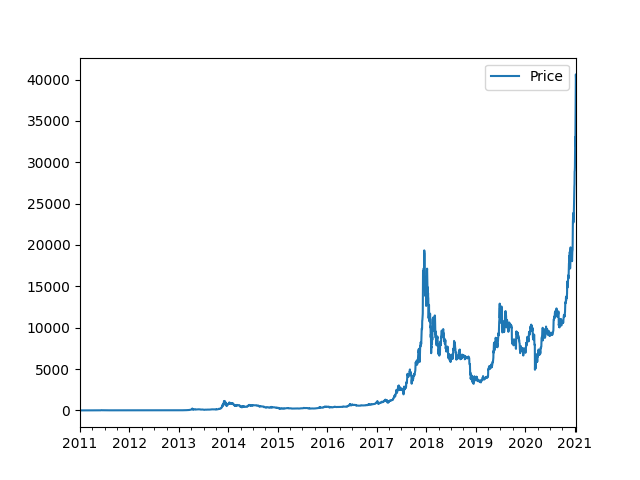

<AxesSubplot:>

In [71]:
data.plot()

# Interpolate to a function
In order to easily evaluate the bitcoin price at a point in time we interpolate this data with linear segments. We can then use this as a python function.

In [72]:
from scipy.interpolate import interp1d

In [74]:
dates = data.index
dates_f = np.array(data.index).astype("float64")

In [76]:
f = interp1d(dates_f, data["Price"], bounds_error=False, fill_value = np.nan)

# Investing costs
Each transaction to buy and sell bitcoin will cost some money to the platform. I have a coinbase account and adopted their transaction costs in the rest of this analysis. You can find the costs [here](https://help.coinbase.com/en/coinbase/trading-and-funding/pricing-and-fees/fees.html).

In [240]:
@np.vectorize
def cost_function(x):
    """If you invest x in dollars, then you will pay (return) in transaction costs"""
    if x <= 10:
        return 0.99
    elif x <= 25:
        return 1.49
    elif x <= 50:
        return 1.99
    elif x <= 200:
        return 2.99
    else:
        return x*0.0149

<IPython.core.display.Javascript object>


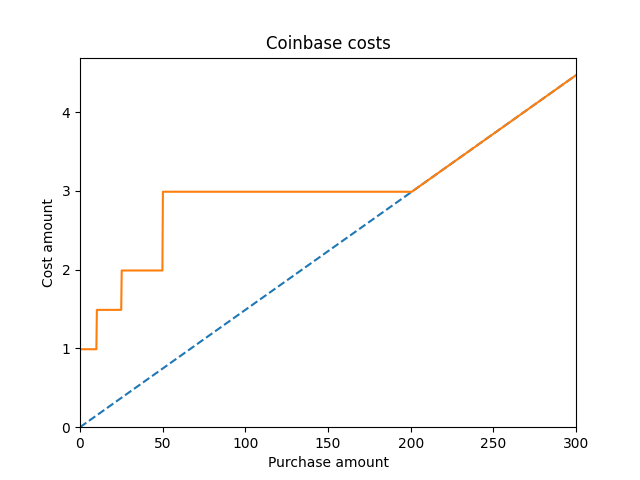

Text(0.5, 1.0, 'Coinbase costs')

In [84]:
fig, ax = plt.subplots()
x = np.linspace(0, 300, 1000)
y = cost_function(x)
ax.plot(x, x*0.0149, linestyle="--")
ax.plot(x, y)
ax.set_xlabel("Purchase amount")
ax.set_ylabel("Cost amount")
ax.set_xlim(0,300)
ax.set_ylim(0,None)
ax.set_title("Coinbase costs")

Above 200 euro or dollar, a fixed rate is charged. Below that, the costs are slightly higher. You are best off closest to the line, so at price points 200 eur, 50 eur, 25 eur and 10 eur.

# Calculating returns
We assume we have X amount of money to "invest" every month. But we don't know how often we want to invest (frequency). So if we invest four times per month, we buy bitcoin for X/4 each time. How important is the time you start investing? We must include the start date in the calculation. When does the portfolio get evaluated? This is the end time. Since the bitcoin price is in USD we assume you invest in this currency.

In [241]:
@np.vectorize
def calculate_value(amount, start, frequency=1, end=None):
    """
    Calculates bitcoin portfolio stats for different DCA strategies
    
    Parameters
    ----------
    amount : float
        the amount to invest on a monthly basis
    start : datetime.datetime
        start date of investing (datetime object)
    frequency : float
        number of times per month to invest. Can also be a fraction, e.g.
        0.5 means you invest once every 2 months.
    end : datetime.datetime
        end date of investing (datetime object). This will default to "yesterday".
        
    Returns
    -------
    total_value : float
        the amount of dollars you have at the end date
    total_fees : float
        the total amount of dollars in fees you paid
    total_invested : float
        the total amount of dollars you put into the account
    gain : float
        the total amount of dollars you gained over the investment period (total_value - total_invested)
    relative_gain : float
        gain/total_invested in percent
    gain_per_year : float
        relative_gain / investment period in years
    """
    if end is None:
        end = datetime.combine(date.today() - timedelta(days=1), time(0,0,0))
    # time points of purchasing
    x = pd.date_range(start, end, freq=f"{int(1/frequency*365/12*24)}h")
    x_u = np.array(x).astype("float64")
    purchase_prices = f(x_u)
    # amount you invest on each purchase
    invest_amount = amount/frequency
    fees = np.ones(x.shape[0])*cost_function(invest_amount)
    # the amount of btc you purchased
    btc_purchased = (invest_amount - fees)/purchase_prices
    total_fees = np.sum(fees)
    evaluation_price = f(end.timestamp()*1e9)
    # value of all the btcs at the end date
    total_value = np.sum(btc_purchased)*evaluation_price
    total_invested = x.shape[0]*invest_amount
    gain = total_value - total_invested
    relative_gain = gain / total_invested * 100
    years = (end.timestamp() - start.timestamp())/3600/24/365
    gain_per_year = relative_gain / years
    return total_value, total_fees, total_invested, gain, relative_gain, gain_per_year

# Testing the function for different investment amounts and frequencies
Let's say you started "investing" near the peak of ~2018 and invested until 1/1/2021, what would be the result if you invested from 10-500 dollars each month with different frequencies? What would be your average annual return?

In [272]:
amounts = np.linspace(10, 500, 300)
frequency = np.linspace(1/12, 5)#1 time year year vs 5 times per month

X, Y = np.meshgrid(amounts, frequency)

results = calculate_value(amount = X,
                          start = datetime(2018, 1, 1, 0, 0, 0),
                          frequency = Y,
                          end = datetime(2021, 1, 1, 0, 0, 0))

<IPython.core.display.Javascript object>


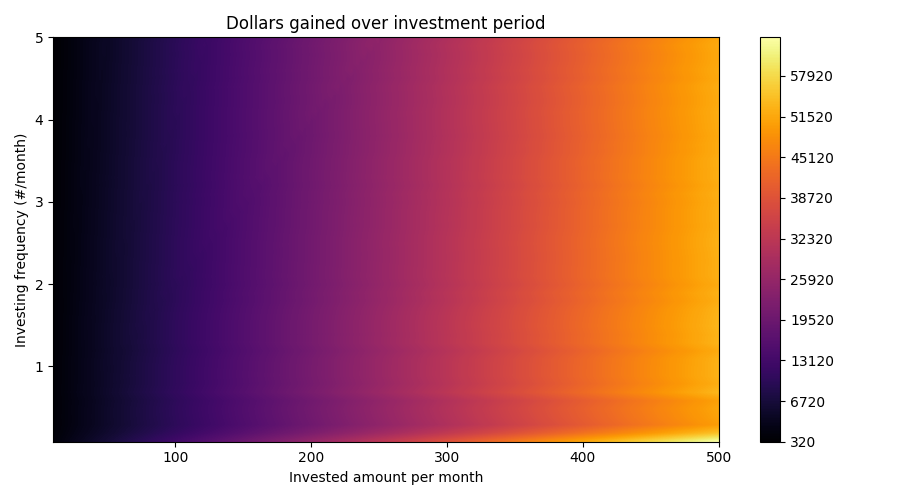

In [281]:
fig, ax = plt.subplots(figsize=(9, 5))
im = ax.contourf(X, Y, results[3], 1000, cmap="inferno")

fig.colorbar(im, ax=ax)

ax.set_xlabel("Invested amount per month")
ax.set_ylabel("Investing frequency (#/month)")

ax.set_title("Dollars gained over investment period")

fig.tight_layout()

As one would expect, the gains you make are a nearly linear function of what you put in each month. If you invested 10 dollar each month you would end up with about 300 dollars in profit. If you invested 500 dollars each month you would have about 50000 dollars in profit over the time period. As you go down the frequency scale (a few big infrequent purchases) it is possible you could have made more due to luck with choosing this start time - the price point at which you buy becomes more important. However this may not be the case in general - if we choose a different start time, the gain may be lower.

To gauge the effect of fees, observe the following plot: relative amount of fees paid over the investment period.

<IPython.core.display.Javascript object>


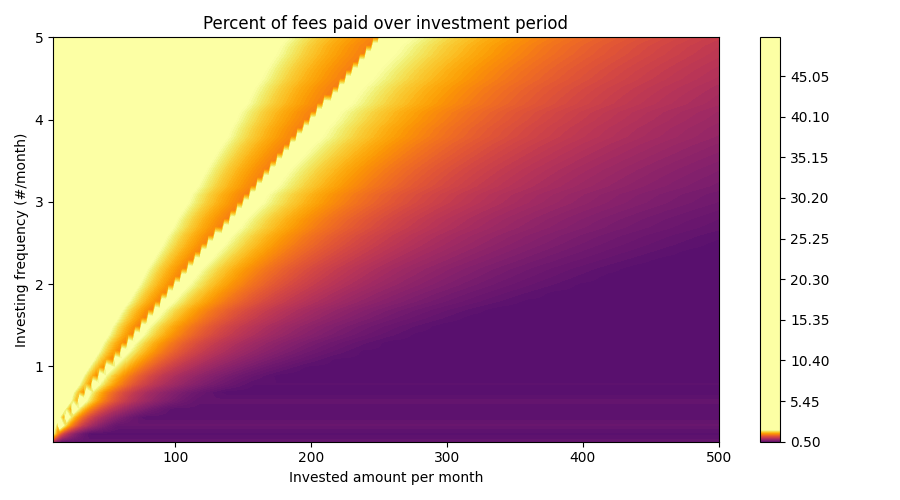

Locator attempting to generate 1972 ticks ([0.5, ..., 49.775000000000006]), which exceeds Locator.MAXTICKS (1000).


In [309]:
fig, ax = plt.subplots(figsize=(9, 5))
im = ax.contourf(X, Y, results[1]/results[3]*100, 2000, cmap="inferno", vmin=0, vmax=2)

cb = fig.colorbar(im)

ax.set_xlabel("Invested amount per month")
ax.set_ylabel("Investing frequency (#/month)")

ax.set_title("Percent of fees paid over investment period")

fig.tight_layout()

You see that it becomes totally uninteresting to invest frequently with low amounts - costs can go up to 50 percent in this case. As you invest larger amounts
you can afford more frequent investments. Total fees should ideally not exceed 2 percent - a value already high for funds if you invest in stock. Let's now look at the relative annual returns, which will also be influenced by the cost of fees.

<IPython.core.display.Javascript object>


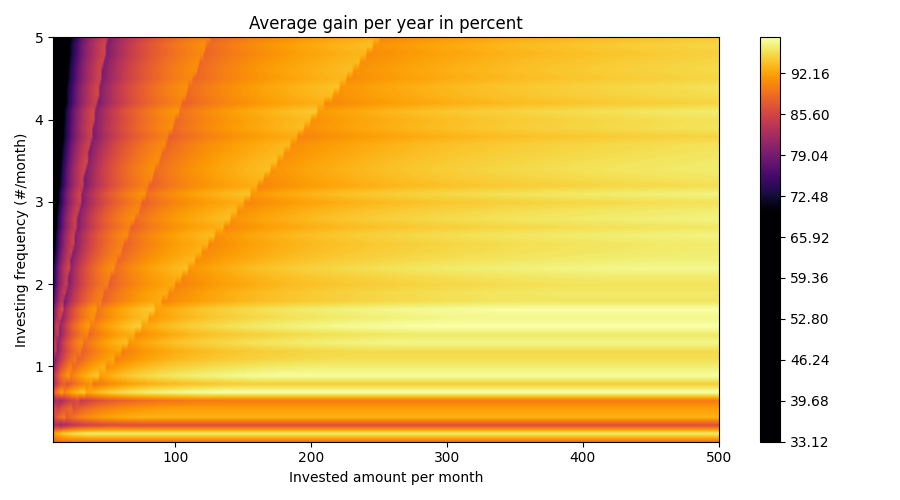

In [312]:
fig, ax = plt.subplots(figsize=(9, 5))
im = ax.contourf(X, Y, results[5], 1000, cmap="inferno", vmin=70)

cb = fig.colorbar(im)

ax.set_xlabel("Invested amount per month")
ax.set_ylabel("Investing frequency (#/month)")

ax.set_title("Average gain per year in percent")

fig.tight_layout()

Here you nicely see the effect both of the transaction fees and the timing. The slanted lines are the effect of the discontinuities in the transaction fee function. The horizontal lines are purely the effect of price fluctuation and market timing. As one would expect, fluctuation becomes more severe with lower investing frequency. For this time period you would get the most value for money if you invested once to twice per month. But what if we choose a different start time?

# The effect of timing
Let's explore how start time, end time, and invest frequency influence our average return, our gain per year. We will assume we are still invested today. We will assume first a high investing amount so that fees are not important at all, like 500 eur. We will time our start times in 1 week intervals.

First we look at the case where you bought the peak of 2018. You did DCA going up until 2019. The plot shows your total gain relative to your total invested capital, as a function of frequency and investment start date. You can see that in the vast majority of cases you make a loss of up to 70% in total, especially if you started buying on the peak. Only if you started investing in the beginning of 2017 could you make a massive profit. By July you were already too late. If you started investing close to the end date it looks like you are making a profit but this is mainly due to fluctuations having a bigger influence

In [360]:
endtime = datetime(2019, 1, 1, 0, 0, 0)
start_times = pd.date_range("2017-01-01", endtime, freq="1W")
start_times = start_times.to_pydatetime()
frequency = np.linspace(1/12, 5) #1 time year year vs 5 times per month

X, Y = np.meshgrid(start_times, frequency)

In [361]:
results = calculate_value(amount = 500,
                          start = X,
                          frequency = Y,
                          end = endtime)

<IPython.core.display.Javascript object>


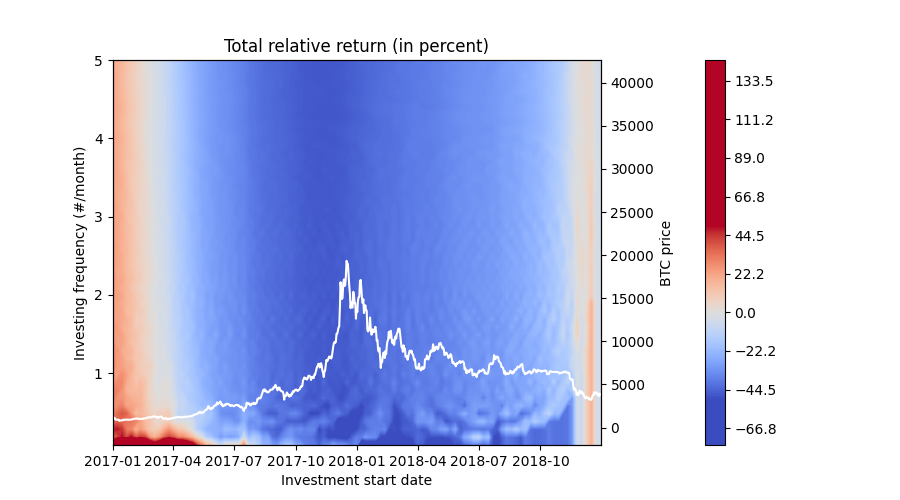

(17167.0, 17895.0)

In [362]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_title("Total relative return (in percent)")
cp = ax.contourf(X, Y, results[4], 1000, cmap="coolwarm", vmin=-50, vmax=50)
fig.colorbar(cp, ax=ax, pad=0.15)
ax.set_xlabel("Investment start date")
ax.set_ylabel("Investing frequency (#/month)")
ax2=ax.twinx()
ax2.plot(data.index, data["Price"], color="white")
ax2.set_ylabel("BTC price")
ax.set_xlim(np.min(X), np.max(X))

What if you HODL'd until 2020? Then no matter when you started buying during the beak peak of 2018, you would have come out positive. If you started in the extended decline of 09/2019 you would have made losses.

In [363]:
endtime = datetime(2020, 1, 1, 0, 0, 0)
start_times = pd.date_range("2017-01-01", endtime, freq="1W")
start_times = start_times.to_pydatetime()
frequency = np.linspace(1/12, 5) #1 time year year vs 5 times per month

X, Y = np.meshgrid(start_times, frequency)

In [364]:
results = calculate_value(amount = 500,
                          start = X,
                          frequency = Y,
                          end = endtime)

<IPython.core.display.Javascript object>


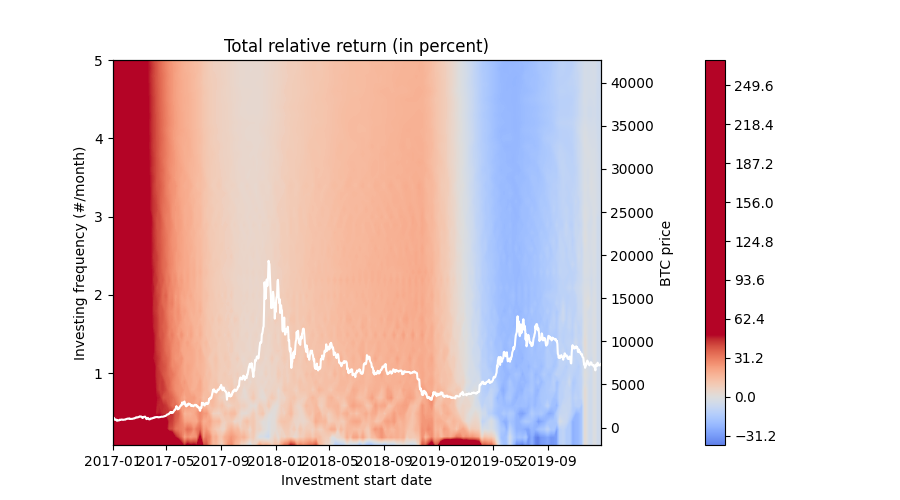

(17167.0, 18259.0)

In [365]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_title("Total relative return (in percent)")
cp = ax.contourf(X, Y, results[4], 1000, cmap="coolwarm", vmin=-50, vmax=50)
fig.colorbar(cp, ax=ax, pad=0.15)
ax.set_xlabel("Investment start date")
ax.set_ylabel("Investing frequency (#/month)")
ax2=ax.twinx()
ax2.plot(data.index, data["Price"], color="white")
ax2.set_ylabel("BTC price")
ax.set_xlim(np.min(X), np.max(X))

At present in early 2021, due to the huge present valuations, you would likely come out positive, no matter when you started. If you started in early 2017 and HODL'd, you would be up 10 fold

In [366]:
endtime = datetime(2021, 1, 1, 0, 0, 0)
start_times = pd.date_range("2017-01-01", endtime, freq="1W")
start_times = start_times.to_pydatetime()
frequency = np.linspace(1/12, 5) #1 time year year vs 5 times per month

X, Y = np.meshgrid(start_times, frequency)

In [367]:
results = calculate_value(amount = 500,
                          start = X,
                          frequency = Y,
                          end = endtime)

In [368]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_title("Total relative return (in percent)")
cp = ax.contourf(X, Y, results[4], 1000, cmap="coolwarm", vmin=-500, vmax=500)
fig.colorbar(cp, ax=ax, pad=0.15)
ax.set_xlabel("Investment start date")
ax.set_ylabel("Investing frequency (#/month)")
ax2=ax.twinx()
ax2.plot(data.index, data["Price"], color="white")
ax2.set_ylabel("BTC price")
ax.set_xlim(np.min(X), np.max(X))

<IPython.core.display.Javascript object>

(17167.0, 18623.0)

# Evaluating effect of frequency on return volatility
If we assume we don't know at all when we should enter the market, then we can assume the start date is totally random. So we should estimate our expected returns by looking at the the distribution of returns for each investing frequency period. Let's do a basic mean and standard deviation

In [420]:
endtime = datetime(2021, 1, 1, 0, 0, 0)
start_times = pd.date_range("2017-01-01", endtime, freq="1W")
start_times = start_times.to_pydatetime()
frequency = np.geomspace(1/12/4, 3) #1 time per 4 years vs 3 times per month

X, Y = np.meshgrid(start_times, frequency)
results = calculate_value(amount = 50,
                          start = X,
                          frequency = Y,
                          end = endtime)

In [421]:
fraction = 1 # to throw out the last few datapoints in case you don't want to consider investment periods of a few weeks
mean = (results[4][:,:int(start_times.shape[0]*fraction)]).mean(axis=1)
median = np.median(results[4][:,:int(start_times.shape[0]*fraction)], axis=1)
std = (results[4][:,:int(start_times.shape[0]*fraction)]).std(axis=1)
mini = (results[4][:,:int(start_times.shape[0]*fraction)]).min(axis=1)
maxi = (results[4][:,:int(start_times.shape[0]*fraction)]).max(axis=1)

<IPython.core.display.Javascript object>


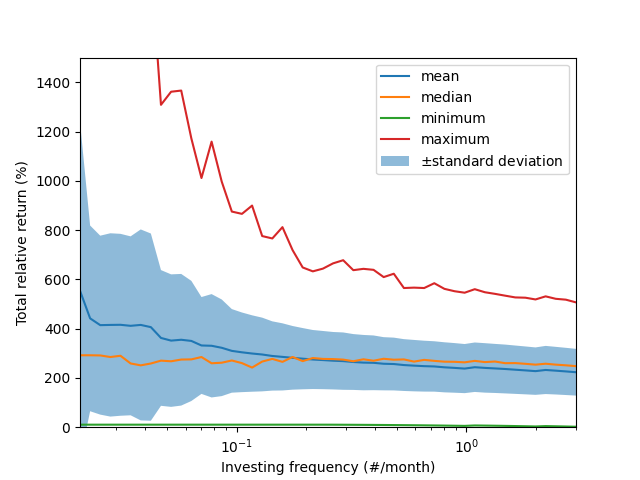

In [422]:
fig, ax = plt.subplots()
ax.set_xscale("log")
#ax.plot(frequency, mean)
ax.plot(frequency, mean, label= "mean")
ax.plot(frequency, median, label= "median")
ax.plot(frequency, mini, label = "minimum")
ax.plot(frequency, maxi, label = "maximum")
ax.fill_between(frequency, mean-std, mean+std, alpha=0.5, label=r"$\pm$standard deviation")
ax.set_xlabel("Investing frequency (#/month)")
ax.set_ylabel("Total relative return (%)")
ax.set_xlim([frequency[0],frequency[-1]])
ax.set_ylim([0,1500])
ax.legend()

As one would expect, the return behavior becomes more eratic with lower frequency. The potential pay offs become larger but so do the losses. At around 1 time per month, the graph stabilizes and investment frequency does not improve long term returns significantly. 

The bottom line seems to be:
* Invest about 1 time per month or per 2 months. 
* Invest at least 50-100 dollars to avoid significant contribution of fees.